# TP3 Alejandro balladares 101118

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") 

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#1Jd247D2BPj4ry7kpzK71fMtnyzOYa9M_
id_train_identity = '1Jd247D2BPj4ry7kpzK71fMtnyzOYa9M_'
downloaded = drive.CreateFile({'id': id_train_identity})
downloaded.GetContentFile('train_identity.csv')

df_train_identity = pd.read_csv('train_identity.csv')
#df_train_identity.head().T

In [5]:
#"1ToBfhZrshAHYsrW3FXVPxuPT-Vm5-8NB"

id_train_transaction = '1ToBfhZrshAHYsrW3FXVPxuPT-Vm5-8NB'
downloaded = drive.CreateFile({'id': id_train_transaction})
downloaded.GetContentFile('train_transaction.csv')

df_train_transaction = pd.read_csv('train_transaction.csv')
#df_train_transaction.head().T

# Parte II: Machine Learning Baseline (4 puntos)

Vamos a construir un modelo muy sencillo para saber qué es lo peor que podemos hacer,
en general esta es una tarea muy importante que queremos que repitan en sus proyectos
de machine learning. ¿Por qué?

● Navaja de Ockam: “Cuando se ofrecen dos o más explicaciones de un fenómeno, es
preferible la explicación completa más simple; es decir, no deben multiplicarse las
entidades sin necesidad.” ¿Para qué desarrollar un modelo super complejo si capaz
es peor o casi igual que uno muy sencillo?

● Nos sirve para saber si estamos usando bien los modelos más complejos, si su
score nos da peor al baseline probablemente se deba a un error de código.

● Nos sirve para rápidamente saber que tan complejo es un problema.

● Los modelos simples son fáciles de entender.

Utilice todos las columnas del dataset (exceptuando ids únicos) con algún encoding
donde sea necesario para entrenar una regresión logística y utilizando búsqueda de
hiperparametros y garantizando la reproducibilidad de los resultados cuando el notebook
corriera varias veces. Conteste las preguntas:

● ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el
dataset para validar?)

● Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido?
(guardar el csv con predicciones para entregarlo después)

● ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.


# Criterios de correción

Parte II
Vamos a corregir los siguientes puntos (no pueden restar más de 4 en total):

● Utiliza mal los datos de validación ya sea para obtener el resultado o para buscar
hiper parámetros (-4 puntos), ejemplos: calcular el score con otras labels, calcular el
AUC-ROC usando la predicción binaria y no la probabilidad, el set de validación se
usa para elegir los parámetros pero también está dentro del entrenamiento de cada
modelo, etc.

● El modelo no está bien hecho (-4 puntos), ejemplo: entrenan con las labels o datos
cambiados para algunas filas

● No es capaz de predecir para la competencia o no lo hace correctamente (-4 puntos)

● No es reproducible (-2 puntos)

● No obtiene bien los features más importantes (-2 puntos)

● La predicción en la competencia da menos de 0.5 (-2 puntos)

● La predicción para la competencia tiene errores (-1 punto)

● No utiliza todos los features (-1 punto)

In [6]:
!pip install category_encoders

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
import category_encoders as ce


In [8]:
df_train = pd.merge(df_train_identity, df_train_transaction, how='outer',on='TransactionID')

del df_train_identity
del df_train_transaction

In [9]:
#TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
#TransactionAMT: transaction payment amount in USD
#ProductCD: product code, the product for each transaction
#card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
#addr: address
#dist: distance
#P_ and (R__) emaildomain: purchaser and recipient email domain
#C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
#D1-D15: timedelta, such as days between previous transaction, etc.
#M1-M9: match, such as names on card and address, etc.
#Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relation

columnas=['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5','card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3','C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13','C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9','D10', 'D11', 'D12', 'D13', 'D14', 'D15',
       'M1', 'M2', 'M3', 'M4','M5', 'M6', 'M7', 'M8', 'M9',
       'V1', 'V2', 'V3', 'V4', 'V5','V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15','V16', 'V17', 'V18', 'V19', 'V20', 
       'V21', 'V22', 'V23', 'V24', 'V25','V26', 'V27', 'V28', 'V29', 'V30', 
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 
       'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 
       'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 
       'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 
       'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 
       'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 
       'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 
       'V101', 'V102', 'V103', 'V104','V105', 'V106','V107','V108','V109','V110',
       'V111', 'V112', 'V113', 'V114','V115', 'V116','V117','V118','V119','V120',
       'V121', 'V122', 'V123', 'V124','V125', 'V126','V127','V128','V129','V130',
       'V131', 'V132', 'V133', 'V134','V135', 'V136','V137','V138','V139','V140',
       'V141', 'V142', 'V143', 'V144','V145', 'V146','V147','V148','V149','V150',
       'V151', 'V152', 'V153', 'V154','V155', 'V156','V157','V158','V159','V160',
       'V161', 'V162', 'V163', 'V164','V165', 'V166','V167','V168','V169','V170',
       'V171', 'V172', 'V173', 'V174','V175', 'V176','V177','V178','V179','V180',
       'V181', 'V182', 'V183', 'V184','V185', 'V186','V187','V188','V189','V190',
       'V191', 'V192', 'V193', 'V194','V195', 'V196','V197','V198','V199','V200',
       'V201', 'V202', 'V203', 'V204','V205', 'V206','V207','V208','V209','V210',
       'V211', 'V212', 'V213', 'V214','V215', 'V216','V217','V218','V219','V220',
       'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228','V229',
       'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238','V239',
       'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248','V249',
       'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258','V259',
       'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268','V269',
       'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278','V279',
       'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288','V289',
       'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298','V299',
       'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308','V309',
       'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318','V319',
       'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328','V329',
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338','V339',
       'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
       'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
       'id_21', 'id_22','id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo']


categoricas = []

for columna in columnas:
#for i, columna in enumerate(df_train):
  if df_train[columna].dtype == object:
    categoricas.append(columna)

print(categoricas)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


# Mini analisis de las categoricas

In [10]:
df_train['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [11]:
df_train['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [12]:
df_train['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [13]:
#df_train['P_emaildomain'].value_counts() #muchas

In [14]:
#df_train['R_emaildomain'].value_counts() #muchas

In [15]:
#df_train['M1'].value_counts() #True o false

In [16]:
#df_train['M2'].value_counts() #True o false

In [17]:
#df_train['M3'].value_counts()#True o false

In [18]:
df_train['M4'].value_counts() 

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

In [19]:
#df_train['M5'].value_counts() #True o false

In [20]:
#df_train['M6'].value_counts()#True o false

In [21]:
#df_train['M7'].value_counts()#True o false

In [22]:
#df_train['M8'].value_counts()#True o false

In [23]:
#df_train['M9'].value_counts() #True o false

In [24]:
#df_train['id_12'].value_counts() #NotFound Found

In [25]:
#df_train['id_15'].value_counts() # #Found o Neww o Unknown

In [26]:
#df_train['id_16'].value_counts()  #NotFound Found

In [27]:
df_train['id_23'].value_counts()

IP_PROXY:TRANSPARENT    3489
IP_PROXY:ANONYMOUS      1071
IP_PROXY:HIDDEN          609
Name: id_23, dtype: int64

In [28]:
#df_train['id_27'].value_counts()  #Found o NotFound   

In [29]:
#df_train['id_29'].value_counts() #Found o NotFound   

In [30]:
df_train['id_30'].value_counts() #75

Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
                    ...  
func                   10
iOS 11.4.0              5
Mac OS X 10_13_5        4
Windows                 3
iOS 11.4.1              1
Name: id_30, Length: 75, dtype: int64

In [31]:
df_train['id_31'].value_counts() #130

chrome 63.0              22000
mobile safari 11.0       13423
mobile safari generic    11474
ie 11.0 for desktop       9030
safari generic            8195
                         ...  
M4Tel/M4                     1
Samsung/SCH                  1
LG/K-200                     1
Inco/Minion                  1
Nokia/Lumia                  1
Name: id_31, Length: 130, dtype: int64

In [32]:
df_train['id_33'].value_counts() #260

1920x1080    16874
1366x768      8605
1334x750      6447
2208x1242     4900
1440x900      4384
             ...  
1536x960         1
1120x700         1
1422x889         1
5040x3150        1
3838x2158        1
Name: id_33, Length: 260, dtype: int64

In [33]:
df_train['id_34'].value_counts()

match_status:2     60011
match_status:1     17376
match_status:0       415
match_status:-1        3
Name: id_34, dtype: int64

In [34]:
#df_train['id_35'].value_counts() #True o false

In [35]:
#df_train['id_36'].value_counts()#True o false

In [36]:
#df_train['id_37'].value_counts()#True o false

In [37]:
#df_train['id_38'].value_counts()#True o false

In [38]:
#df_train['DeviceType'].value_counts() #desktop o mobile  

In [39]:
df_train['DeviceInfo'].value_counts() #1786

Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
SM-T530            1
F8131              1
WAS-LX2J           1
AKUS               1
ASUS_Z01KD         1
Name: DeviceInfo, Length: 1786, dtype: int64

# Armo mis sets

In [40]:
categoricas_booleanas = ['M1','M2','M3', 'M5','M6','M7','M8','M9','id_12','id_16','id_27', 'id_29', 'id_35','id_36','id_37','id_38']
categoricas_binary = ['P_emaildomain', 'R_emaildomain', 'id_30','id_31','id_33','DeviceInfo']
categoricas_oneHot = ['ProductCD', 'card4', 'card6', 'M4', 'id_15', 'id_23', 'id_28', 'id_34', 'DeviceType']

In [41]:
df_train = df_train.sort_values('TransactionDT',ascending=True)
df_train.drop(columns=['TransactionID'], inplace=True)
#primer valor = 86400 / ultimo valor = 15811131	

In [42]:
limite = int(len(df_train)*0.7)

train = df_train[:limite]
test = df_train[limite:]

In [43]:
Y_train = train['isFraud']
X_train = train.drop(columns=['isFraud']) 
del train

Y_test = test['isFraud']
X_test = test.drop(columns=['isFraud'])
del test

# Encodings

In [44]:
encodings = []

one_hot_encoder = ce.OneHotEncoder(cols=categoricas_oneHot ,handle_unknown='return_nan',return_df=True, use_cat_names=True)
def one_hot_enconding(df_train, encoder):
  one_hot_encoded = encoder.fit_transform(df_train)
  return one_hot_encoded


encoding_booleano = []
def hacerBinario(df, columnas):
  for columna in columnas:
    try:
      columna_encodeada = df[columna].transform(lambda x: 1 if ((x == 'T') | (x == 'Found')) else 0)
      df[columna] = columna_encodeada
    except:
      df.drop(columna, inplace=True)
      encoding_booleano.append(columna)

BinaryEncoder = ce.BinaryEncoder()

def binary_encoder(df_train, encoder):
  BinaryEncodeing = encoder.fit_transform(df_train[categoricas_binary])
  df_train = pd.concat([df_train, BinaryEncodeing], axis=1)
  df_train.drop(columns=categoricas_binary,inplace=True)
  del BinaryEncodeing
  return df_train


In [45]:
X_train = one_hot_enconding(X_train, one_hot_encoder)

hacerBinario(X_train, categoricas_booleanas)
hacerBinario(X_test, categoricas_booleanas)

encoding_booleano

X_train = binary_encoder(X_train, BinaryEncoder)

X_train.fillna(value=0, inplace=True) #no es la mejor opción pero por ahora sirve

In [46]:
#X_train

In [47]:
#Encodeo el set de test

def encodeo_binario(df, columnas):  
  aux = df[columnas]
  aux = BinaryEncoder.transform(aux, override_return_df=True)
  df = pd.concat([df, aux], axis=1)
  df.drop(columns=categoricas_binary, inplace=True)
  del aux
  return df

X_test = one_hot_encoder.transform(X_test, override_return_df=True)
X_test = encodeo_binario(X_test, categoricas_binary)
X_test.fillna(value=0, inplace=True)

# Modelo

In [48]:
model = LogisticRegression(C=1, max_iter=100, random_state=0)
model.fit(X_train,Y_train)

LogisticRegression(C=1, random_state=0)

In [49]:
print(classification_report(Y_train, model.predict(X_train)))
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    398840
           1       0.11      0.00      0.01     14538

    accuracy                           0.96    413378
   macro avg       0.54      0.50      0.49    413378
weighted avg       0.93      0.96      0.95    413378

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    171037
           1       0.00      0.00      0.00      6125

    accuracy                           0.96    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.96      0.94    177162



In [50]:
score_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])
score_test = roc_auc_score(Y_test, model.predict_proba(X_test)[:,1])

print("scores para el train, validacion y test:", score_train, score_test)

scores para el train, validacion y test: 0.6234273748320536 0.6473618499780391


In [51]:
def cross_validation(modelo, df_train, Y_train):
  kfold = KFold(n_splits=5)#, random_state=7506)
  cv_results = cross_val_score(modelo, df_train, Y_train, cv=kfold, scoring="roc_auc", n_jobs=1)

  print(f"Métricas validación cruzada: {cv_results}")
  print(f"Média métricas de validación cruzada: {cv_results.mean()}")

#cross_validation(model, X_train, Y_train,)

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    171037
           1       0.00      0.00      0.00      6125

    accuracy                           0.96    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.96      0.94    177162

Matriz de confusión: 
 [[169707   1330]
 [  6123      2]]
ROC: 
 0.6473618499780391


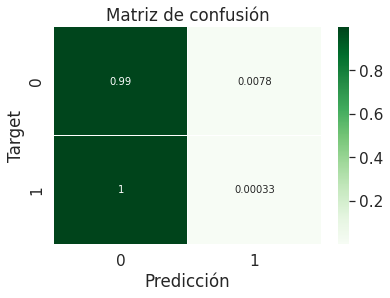

In [52]:
#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred, y_pred_proba):
    print('Reporte de clasificación: \n', classification_report(y_test, y_pred))
    print('Matriz de confusión: \n',confusion_matrix(y_test, y_pred))
    print('ROC: \n', roc_auc_score(y_test, y_pred_proba))

    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()


mostrar_metricas(Y_test, model.predict(X_test), model.predict_proba(X_test)[:,1])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START C=2.857353543863741, penalty=l2.............................
[CV 1/3; 1/5] END C=2.857353543863741, penalty=l2;, score=0.951 total time=  30.7s
[CV 2/3; 1/5] START C=2.857353543863741, penalty=l2.............................
[CV 2/3; 1/5] END C=2.857353543863741, penalty=l2;, score=0.964 total time=  33.1s
[CV 3/3; 1/5] START C=2.857353543863741, penalty=l2.............................
[CV 3/3; 1/5] END C=2.857353543863741, penalty=l2;, score=0.965 total time=  34.5s
[CV 1/3; 2/5] START C=2.607070064105826, penalty=l2.............................
[CV 1/3; 2/5] END C=2.607070064105826, penalty=l2;, score=0.951 total time=  30.9s
[CV 2/3; 2/5] START C=2.607070064105826, penalty=l2.............................
[CV 2/3; 2/5] END C=2.607070064105826, penalty=l2;, score=0.964 total time=  33.0s
[CV 3/3; 2/5] START C=2.607070064105826, penalty=l2.............................
[CV 3/3; 2/5] END C=2.607070064105826, 

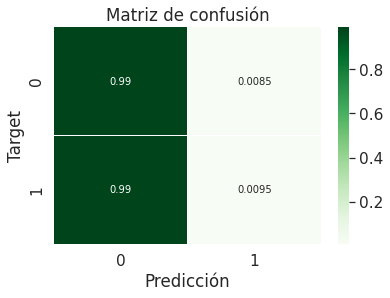

In [53]:
def randomSearch(modelo, kfold=None):
  #distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])
  distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2'])

  clf = RandomizedSearchCV(modelo, distributions, n_iter=5, cv = 3, verbose=100, random_state=7506) #no tuve tiempo para probar más combinaciones
  search = clf.fit(X_train, Y_train) #n_iter = 10 cv = 10 tarda 56 minutos 
  print(search.best_params_)
  
  resultado = search.best_params_
  best_C = resultado['C']
  best_model = LogisticRegression(C=best_C, max_iter=100, random_state=12)
  best_model.fit(X_train.values,Y_train.values)
  mostrar_metricas(Y_test, best_model.predict(X_test), best_model.predict_proba(X_test)[:,1])
  return best_model

best_model = randomSearch(model)


# Importancia de los features

In [55]:
#from matplotlib import pyplot

indices = []
valores = []
importance = model.coef_[0]
for i,v in enumerate(importance):
	if abs(v) > 0.0002:
		indices.append(X_train.columns[i])
		valores.append(v)

Text(0, 0.5, 'Importancia')

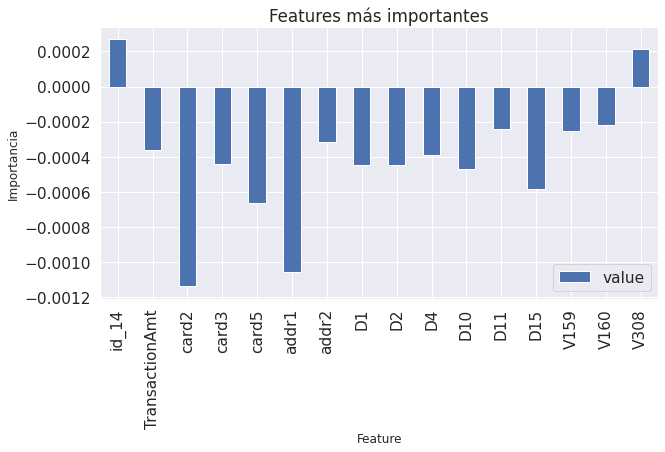

In [56]:
df =pd.DataFrame({'indice': indices, 'value': valores})
df.set_index('indice',inplace=True)
df.plot(kind = 'bar', figsize = (10, 5),  title = "Features más importantes")
plt.xlabel('Feature', fontsize= 12)
plt.ylabel("Importancia", fontsize= 12)

In [57]:
del X_train
del X_test

# Test

In [58]:
id_test_identity ='1NxzemULNRkT-kqjYXeHV0gQmQK98NC1n'
downloaded = drive.CreateFile({'id': id_test_identity})
downloaded.GetContentFile('test_identity.csv')
df_test_identity = pd.read_csv('test_identity.csv')

#df_test_identity.head(5).T


id_test_transaction ='1y-MpYZTrnmzHMcVDPfYkpVFQetOy4zqN'
downloaded = drive.CreateFile({'id': id_test_transaction})
downloaded.GetContentFile('test_transaction.csv')
df_test_transaction = pd.read_csv('test_transaction.csv')
#df_test_transaction.head().T


In [59]:
df_test = pd.merge(df_test_identity, df_test_transaction, how='outer',on='TransactionID')

del df_test_identity
del df_test_transaction


df_test.set_index('TransactionID',inplace=True)
df_test.columns = df_test.columns.str.replace("id-","id_")

hacerBinario(df_test, categoricas_booleanas)
df_test = one_hot_encoder.transform(df_test, override_return_df=True)
df_test = encodeo_binario(df_test, categoricas_binary)

df_test.fillna(value=0, inplace=True)

In [60]:
predicciones = best_model.predict_proba(df_test)[:,1]

In [61]:
from google.colab import files
def generarResultado(df,prediccion):
    df.index.rename('TransactionID',inplace=True)
    df['isFraud'] = prediccion
    resultado = df[['isFraud']]
    resultado.to_csv('resultadoLR.csv')
    files.download('resultadoLR.csv')
    return resultado


In [62]:
prediccion = generarResultado(df_test,predicciones)
prediccion

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,isFraud
TransactionID,
3663586,0.01
3663588,0.01
3663597,0.01
3663601,0.01
3663602,0.03
...,...
4170231,0.02
4170232,0.00
4170235,0.01
